## Beam Search vs Greedy Search

In [1]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import ray
from tqdm import tqdm
ray.init(num_cpus=4, memory=2**32, object_store_memory=2**31)

2020-04-13 20:26:38,555	INFO resource_spec.py:212 -- Starting Ray with 3.96 GiB memory available for workers and up to 2.0 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-13 20:26:41,627	INFO services.py:1148 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '192.168.1.10',
 'redis_address': '192.168.1.10:32658',
 'object_store_address': '/tmp/ray/session_2020-04-13_20-26-38_540361_91429/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-04-13_20-26-38_540361_91429/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-04-13_20-26-38_540361_91429'}

### Creating language model

Define some functions to create probability distributions that will act as our language model

In [2]:
def create_probs(n, length, temp=1):
    '''Create n probability distributions of a specified length'''
    if n == 1:
        probs = np.random.random((length,))*temp
        probs = np.exp(probs)/np.exp(probs).sum()
    else:
        probs = np.random.random((n, length))*temp
        probs = np.exp(probs)/np.exp(probs).sum(axis=1).reshape(-1,1)
    probs = probs.astype(np.float32)
    return probs

In [3]:
probs_temp1 = create_probs(3,10, temp=1)
probs_temp10 = create_probs(3,10, temp=10)

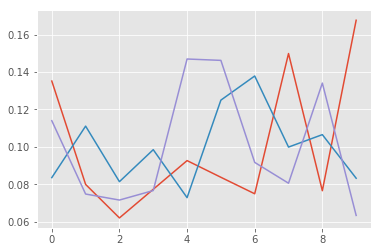

In [4]:
plt.style.use('ggplot')
plt.plot(probs_temp1.T);

Increasing the temperature makes the more likely samples more likely

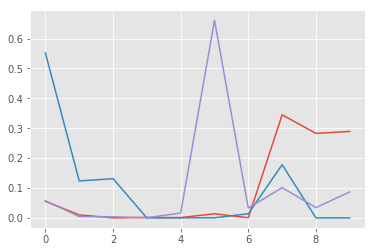

In [5]:
plt.plot(probs_temp10.T);

In [6]:
def create_conditional_probs(vocab_length, sequence_length, memory, temperature):
    '''Create conditional probability distribution for each character in a sequence with a specified memory'''
    conditional_probabilites = []
    for i in range(0, sequence_length):
        max_preceding_chars = min(i, memory)
        n_probs = vocab_length**(max_preceding_chars)
        probs = create_probs(n_probs,vocab_length, temp=temperature)
        probs = probs.reshape((vocab_length,)*(max_preceding_chars+1))
        conditional_probabilites.append(probs)
    return conditional_probabilites

In [7]:
def get_log_prob_of_sequence(conditional_probabilites, seq=[]):
    '''Return log probability of a sequence of characters'''
    p = np.log(1)
    for i in range(len(seq)):
        p += np.log(conditional_probabilites[i][tuple(seq[max(0, i - memory):i+1])])
    return p

In [8]:
def get_most_likely_sequence(conditional_probabilites):
    '''Exhaustivley enumerate all joint probability distributions and find the most likely sequence'''
    vocab_length = len(conditional_probabilites[0])
    possible_sequences = list(product(range(vocab_length), repeat=sequence_length))
    P = [get_log_prob_of_sequence(conditional_probabilites, seq) for seq in possible_sequences]
    x = np.argmax(P)
    p = P[x]
    return possible_sequences[x], p 

Creating a 'model' which uses the probability distributions created by the above to predict the next character in a sequence based on previous characters, in a real example this would be some sort of recurrent neural network or transform e.g. see https://arxiv.org/abs/1409.3215


In [9]:
class Model():
    def __init__(self, conditional_probabilites, vocab_length, memory):
        self.prob = conditional_probabilites
        self.vocab_length = vocab_length
        self.memory = memory
        
    def predict_next(self, prev_chars=[]):
        element = len(prev_chars)
        seq_memory = prev_chars[-self.memory:]
        if element == sequence_length:
            return

        p = self.prob[element][tuple(seq_memory)]
        return p

In [10]:
def get_top_n(arr, n):
    '''Return largest n indices and values from array'''
    flat = arr.flatten()
    idxs = np.argpartition(flat, -n)[-n:]
    idxs = idxs[np.argsort(-flat[idxs])]
    ps = flat[idxs]
    idxs = np.unravel_index(idxs, arr.shape)
    # idxs is a tuple with first element
    # idxs = [tuple(idx) for idx in np.swapaxes(idxs, 0, 1)]
    return idxs, ps

In [11]:
def greedy_search(model):
    '''Decode an output from a model using greedy search'''
    X = []
    p = np.log(1)
    for i in range(sequence_length):
        distribution = model.predict_next(X)
        x = np.argmax(distribution)
        x = np.squeeze(x)
        p += np.log(distribution[x])
        X.append(x)

    return X, p 

In [12]:
def beam_search(model, beam_width):
    '''Decode an output from a model using beam search with specified beam_width'''
    beam_seq = np.empty((beam_width, 1), dtype=np.int32)
    beam_log_probs = np.zeros((beam_width,1))
    vocab_length = model.vocab_length
    prob_char_given_prev = np.empty((beam_width, vocab_length))
    
    # Next characters
    done = False
    first_char = True
    while not done:
        
        if first_char:
            prob_first_char = model.predict_next([])
            log_prob_first_char = np.log(prob_first_char)
            top_n, log_p = get_top_n(log_prob_first_char, beam_width)
            beam_seq[:,0] = top_n[0]
            beam_log_probs[:,0] += log_p
            first_char = False
        else:
        
            for beam in range(beam_width):
                prob_char_given_prev[beam] = model.predict_next(beam_seq[beam])
            log_prob_char_given_prev = np.log(prob_char_given_prev)
            log_prob_char = beam_log_probs + log_prob_char_given_prev
            top_n, log_p = get_top_n(log_prob_char, beam_width)
            beam_seq = np.hstack((beam_seq[top_n[0]], top_n[1].reshape(-1,1)))

            beam_log_probs = log_p.reshape(-1,1)
        
        if len(beam_seq[0]) == sequence_length:
            done = True
        
    return beam_seq, beam_log_probs

## Experiments

In [13]:
vocab_length = 30
sequence_length = 3
memory = 1
temperature = 1

In [14]:
conditional_probs = create_conditional_probs(vocab_length, sequence_length, memory, temperature)

In [15]:
conditional_probs[2].shape

(30, 30)

Instantiate our 'model' and set up our greedy and beam search decoders

In [16]:
model = Model(conditional_probs, vocab_length, memory)
greedy = greedy_search(model)
beam = beam_search(model, 4)

In [17]:
best = get_most_likely_sequence(conditional_probs)

In [18]:
print('beam decodings: \n', beam)
print('greedy decodings: \n', greedy)
print('actual best decoing: \n', best)

beam decodings: 
 (array([[ 2, 22, 17],
       [ 2, 15, 18],
       [ 2,  0, 12],
       [ 2,  0,  8]]), array([[-8.80453935],
       [-8.85614164],
       [-8.8647291 ],
       [-8.87078978]]))
greedy decodings: 
 ([2, 0, 12], -8.864729166030884)
actual best decoing: 
 ((2, 22, 17), -8.804539203643799)


### Experiment 1 - Decoder accuracy over various vocab lenghts

In [23]:
n_experiments = 64
beam_widths = range(1,11, 2)
sequence_length = 4
memory = 2
vocab_lengths = range(4, 20, 2)
n_lengths = len(vocab_lengths)
greedy_ratio = np.empty((n_lengths, n_experiments))
beam_ratio = np.empty((n_lengths, n_experiments, len(beam_widths)))

In [20]:
@ray.remote
def experiment_1():
    greedy_ratio = np.empty((n_lengths))
    beam_ratio = np.empty((n_lengths, len(beam_widths)))
    for v, vocab_length in enumerate(vocab_lengths):
        conditional_probs = create_conditional_probs(vocab_length, sequence_length, memory, temperature)
        model = Model(conditional_probs, vocab_length, memory)
        
        
        best_greedy = greedy_search(model)[1]
        best_beams = [beam_search(model, min(beam_width, vocab_length))[1][0] for beam_width in beam_widths]
#         best_beam = np.squeeze(beam_search(model, beam_width)[1][0])
        actual_best = get_most_likely_sequence(conditional_probs)[1]

        greedy_ratio[v] = np.exp(best_greedy - actual_best)
        beam_ratio[v, :] = np.squeeze(np.exp(best_beams - actual_best))
    return beam_ratio, greedy_ratio

In [21]:
futures = [experiment_1.remote() for i in range(n_experiments)]
results = ray.get(futures)

In [24]:
for i in range(n_experiments):
    beam_ratio[:,i], greedy_ratio[:,i] = results[i]
np.savez('experiment_1-results.npz', beam=beam_ratio, greedy=greedy_ratio)

In [ ]:
experiment_1_results = np.load('experiment_1-results.npz')
beam_ratio = experiment_1_results['beam']
greedy_ratio = experiment_1_results['greedy']

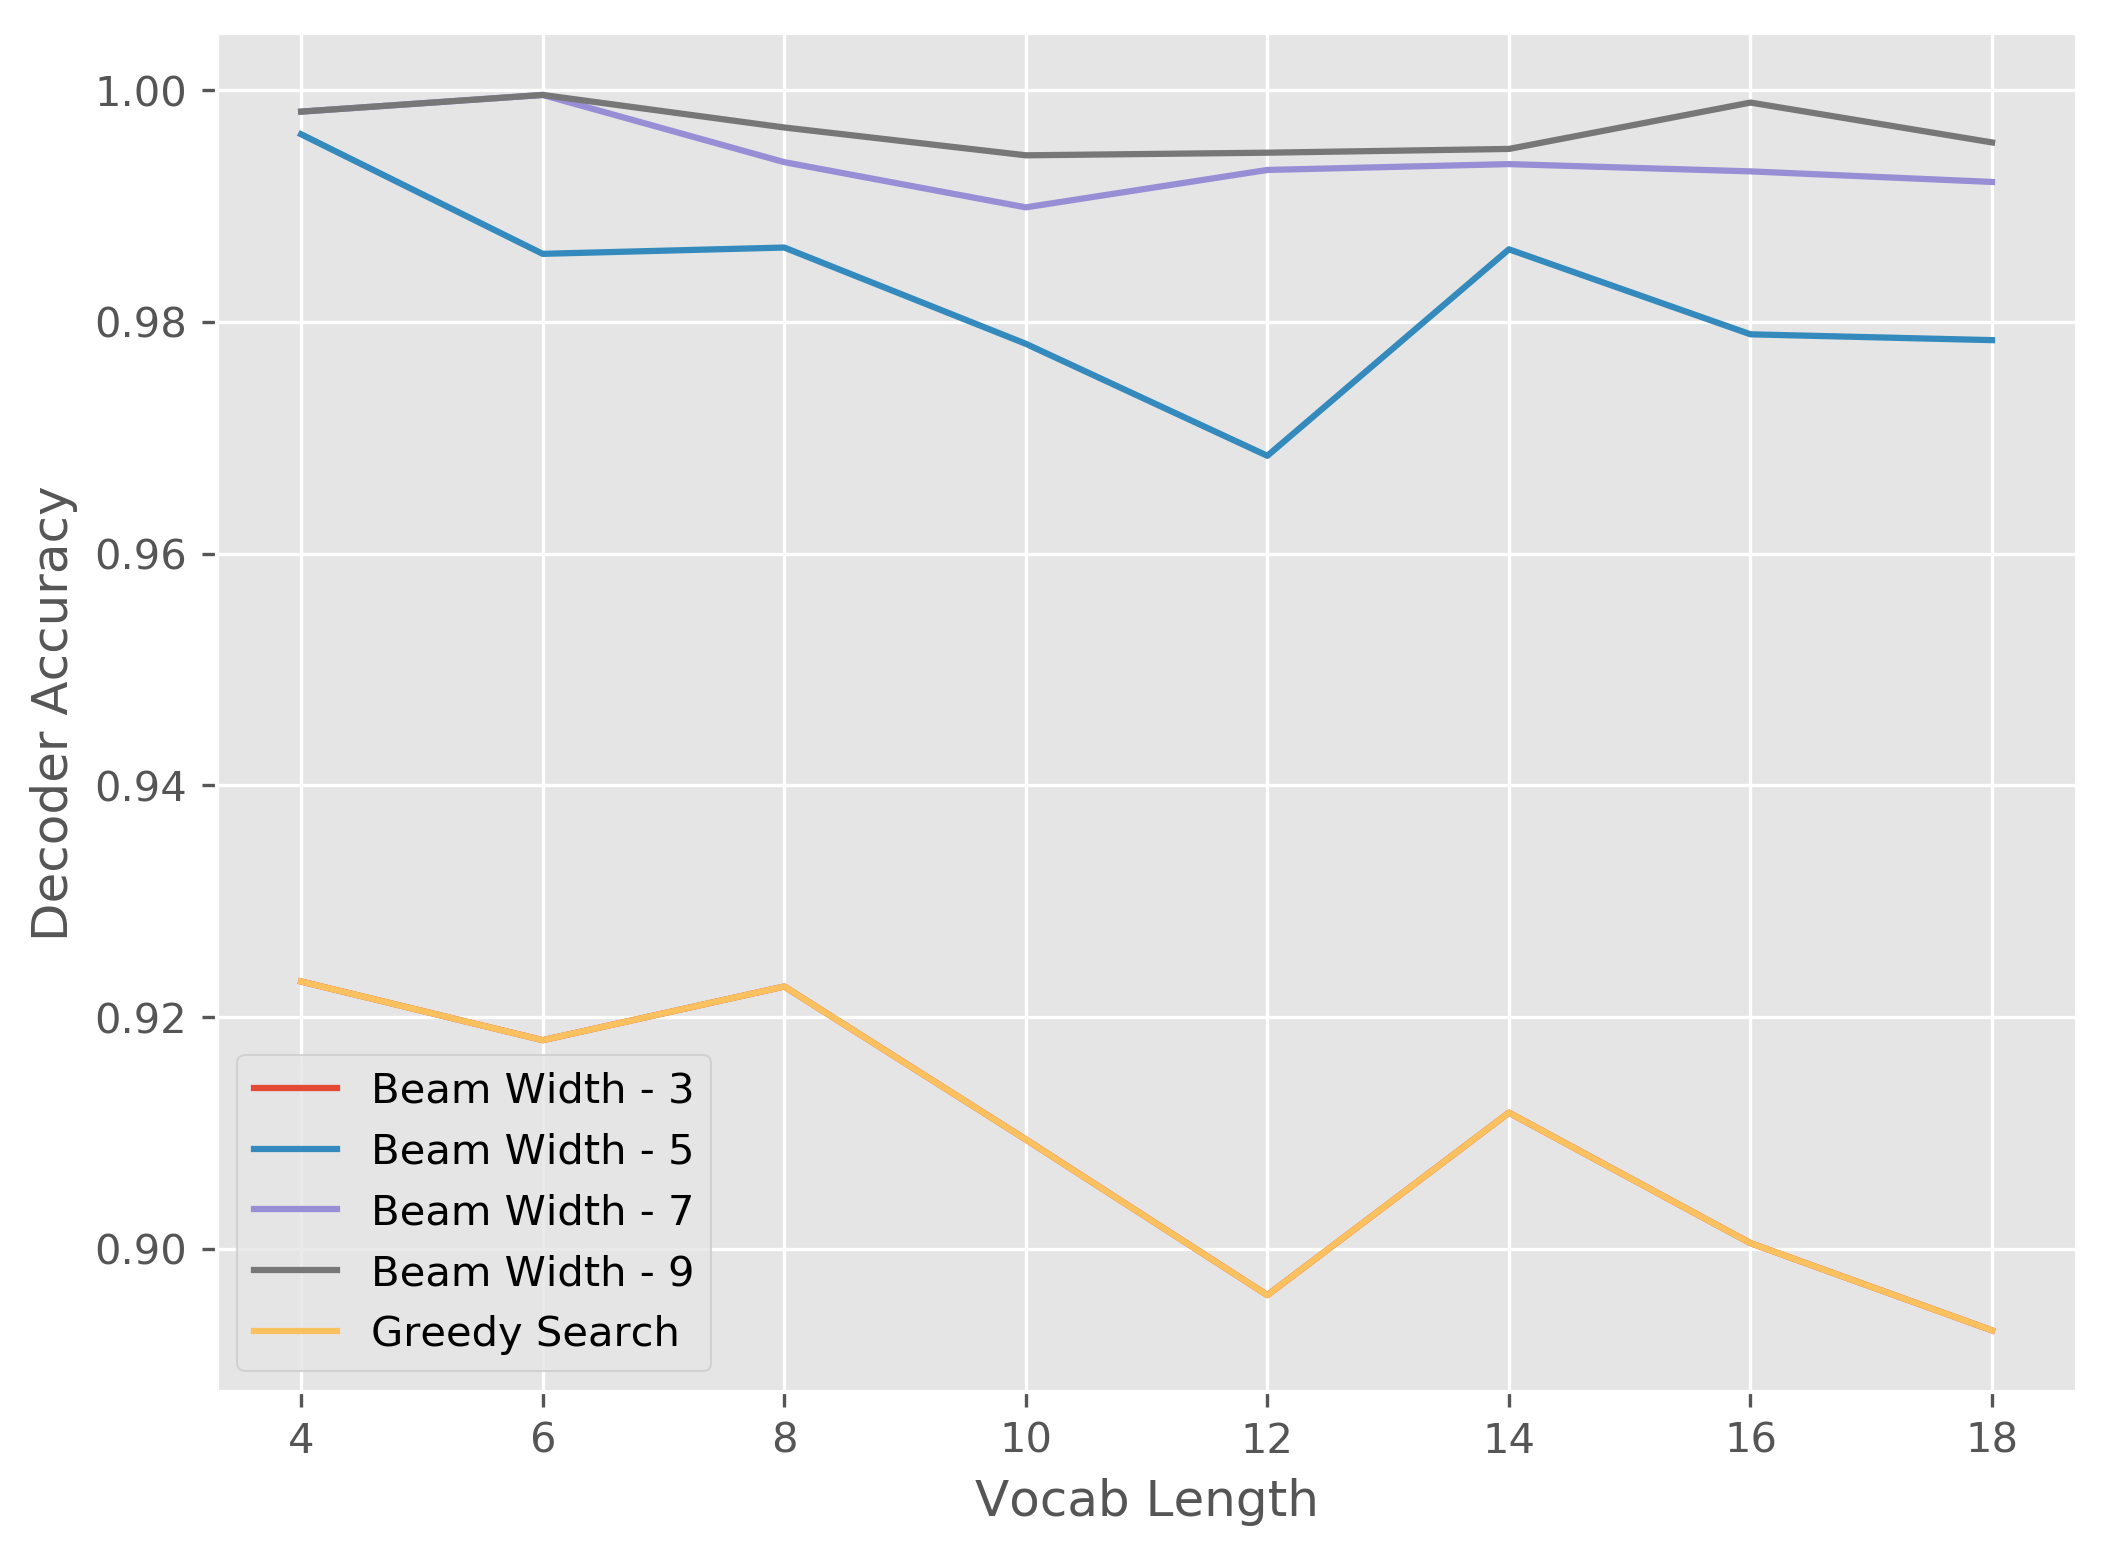

In [31]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8,6), ncols=1, nrows=1, dpi=300)
for beam, beam_width in enumerate(beam_widths[1:]):
    ax.plot(vocab_lengths, beam_ratio[:,:,beam].mean(axis=1), label=f'Beam Width - {beam_width}')
ax.plot(vocab_lengths, greedy_ratio.mean(axis=1), label='Greedy Search');
ax.set_xlabel('Vocab Length')
ax.set_ylabel('Decoder Accuracy')
ax.legend()
plt.show()
fig.tight_layout()
fig.savefig('graphs/decoder-accuracy.png')

### Experiment 2 - Decoder accuracy with beam width

In [14]:
n_experiments = 32
memory = 1
sequence_length = 3
beam_widths = range(1,11, 2)
vocab_lengths = range(100, 4000, 250)
temperature = 1
n_lengths = len(vocab_lengths)


In [28]:
# @ray.remote
def experiment_2():
    beam_greedy_ratio = np.empty((n_lengths, len(beam_widths)))
    for v, vocab_length in enumerate(vocab_lengths):
        conditional_probs = create_conditional_probs(vocab_length, sequence_length, memory, temperature)
        model = Model(conditional_probs, vocab_length, memory)

        best_greedy = greedy_search(model)[1]            
        best_beams = [beam_search(model, min(beam_width, vocab_length))[1][0] for beam_width in beam_widths]
        beam_greedy_ratio[v, :] = np.squeeze(np.exp(best_beams - best_greedy))
    return beam_greedy_ratio

In [29]:
temperature = 1
# futures = [experiment_2.remote() for i in range(n_experiments)]
# results = ray.get(futures)

futures = [experiment_2() for i in tqdm(range(n_experiments))]
results_temp1 = futures

100%|██████████| 32/32 [10:07<00:00, 18.98s/it]


In [30]:
temperature = 10
# futures = [experiment_2.remote() for i in range(n_experiments)]
# results = ray.get(futures)

futures = [experiment_2() for i in tqdm(range(n_experiments))]
results_temp10 = futures

100%|██████████| 32/32 [09:53<00:00, 18.54s/it]


In [31]:
beam_greedy_ratio = np.empty((2, n_lengths, n_experiments, len(beam_widths)))
for i in range(n_experiments):
    beam_greedy_ratio[0, :,i,:] = results_temp1[i]
    beam_greedy_ratio[1, :,i,:] = results_temp10[i]
np.save('experiment_2-results', beam_greedy_ratio)

In [15]:
beam_greedy_ratio = np.load('experiment_2-results.npy')

In [ ]:
fig1, ax1 = plt.subplots(figsize=(8,6), dpi=300)
fig2, ax2 = plt.subplots(figsize=(8,6), dpi=300)
ax = [ax1, ax2]

for beam, beam_width in enumerate(beam_widths):
    ax[0].plot(vocab_lengths, beam_greedy_ratio[0, :, :, beam].mean(axis=1), label=f'Beam Width - {beam_width}')
    ax[1].plot(vocab_lengths, beam_greedy_ratio[1, :, :, beam].mean(axis=1), label=f'Beam Width - {beam_width}')
for a in ax:
    a.set_xlabel('Vocab Length')
    a.legend()
    a.set_ylabel('Ratio of Beam Search to Greedy Search')
ax[0].set_title('Temperature = 1')
ax[1].set_title('Temperature = 10')
fig1.tight_layout()
fig2.tight_layout()
plt.show()
fig1.savefig('ratio-of-beam-to-greedy-temp1.jpg')
fig2.savefig('ratio-of-beam-to-greedy-temp10.jpg')